We begin by defining the `device` to be used. By default, this is set to cpu, but if cuda is available, then we set `device` to cuda.



In [14]:
import torch

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

device

'cpu'

The dataset can be found on [zenodo.org](https://zenodo.org/records/3549595). Incidentally, the dataset can also be found on [Kaggle](https://www.kaggle.com/datasets/mexwell/lidar-data-for-tree-species-classification). This allows us to import the data as follows. Note that this requires you, the user, to upload a file called `kaggle.json`, which you can acquire by creating an API Token with Kaggle. For more instructions, refer to this [tutorial](https://www.kaggle.com/discussions/general/74235).

# Downloading the Data

In [4]:
from google.colab import files
files.upload()  # Upload kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mexwell/lidar-data-for-tree-species-classification
!unzip -o lidar-data-for-tree-species-classification.zip -d lidar-data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mexwell/lidar-data-for-tree-species-classification
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 79.0M/81.0M [00:00<00:00, 820MB/s]
100% 81.0M/81.0M [00:00<00:00, 812MB/s]
Archive:  lidar-data-for-tree-species-classification.zip
  inflating: lidar-data/dataset_1_training_test.csv  
  inflating: lidar-data/dataset_1_unlabeled_set.csv  
  inflating: lidar-data/dataset_2_training_test.csv  
  inflating: lidar-data/dataset_2_unlabeled_set.csv  


# **Supervised Learning on the Labeled Dataset**

## Data Preprocessing

We use `data_preprocessing.py` to merge the labeled datasets into a single dataframe.

In [15]:
from data_preprocessing import process_labeled_data
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
full_labeled_df = process_labeled_data(
    ['/content/lidar-data/dataset_1_training_test.csv',
     '/content/lidar-data/dataset_2_training_test.csv']
    )
full_labeled_df.head()

,zmean,zsd,zskew,zkurt,zentropy,imean,isd,iskew,ikurt,ipcumzq30,ipcumzq50,ipcumzq70,dtm,aspect,slope,Species,Species Number
0,0.000000,0.015868,0.347542,0.005737,0.396236,0.142131,0.082381,0.201176,0.027792,0.451379,0.438797,0.398530,0.774774,0.603841,0.366868,Green alder,5
1,0.000676,0.016100,0.348519,0.006269,0.414225,0.720889,0.709801,0.229452,0.018400,0.342682,0.260413,0.236177,0.834930,0.496024,0.389383,European Larch,1
2,0.002541,0.020247,0.344087,0.007119,0.421639,0.185853,0.137224,0.239136,0.028446,0.400164,0.449852,0.552638,0.912703,0.731446,0.498175,Green alder,5
3,0.003840,0.025313,0.353304,0.006561,0.475403,0.124606,0.073536,0.235840,0.045376,0.388518,0.405317,0.477046,0.785316,0.790922,0.410597,Green alder,5
4,0.004566,0.022959,0.344277,0.005614,0.452551,0.099862,0.049907,0.144789,0.006673,0.399161,0.430855,0.440310,0.228426,0.212406,0.240561,Other broadleaves,2


## Exploratory Data Analysis

Before splitting the data off into training/validation/test sets, let's first conduct some EDA.

In [5]:
full_labeled_df['Species'].value_counts()

,count
Species,
Norway Spruce,1898
European Larch,694
Other broadleaves,686
Silver fir,566
Broadleaves,216
Green alder,159
Pines,112
Scots Pine,73


The dataset is visibly unabalanced. The top three most frequent species account for about 74% of the dataset. This motivates the use of SMOTE to create artificial data samples for the minority classes.

In [6]:
features = full_labeled_df.columns[:-2]
features

Index(['zmean', 'zsd', 'zskew', 'zkurt', 'zentropy', 'imean', 'isd', 'iskew',
       'ikurt', 'ipcumzq30', 'ipcumzq50', 'ipcumzq70', 'dtm', 'aspect',
       'slope'],
      dtype='object')

The features appear to fall into three broad categories: height, intensity, and topographical.

In [7]:
height_features = features[0:5]
intensity_features = features[5:12]
topographical_features = features[12:]

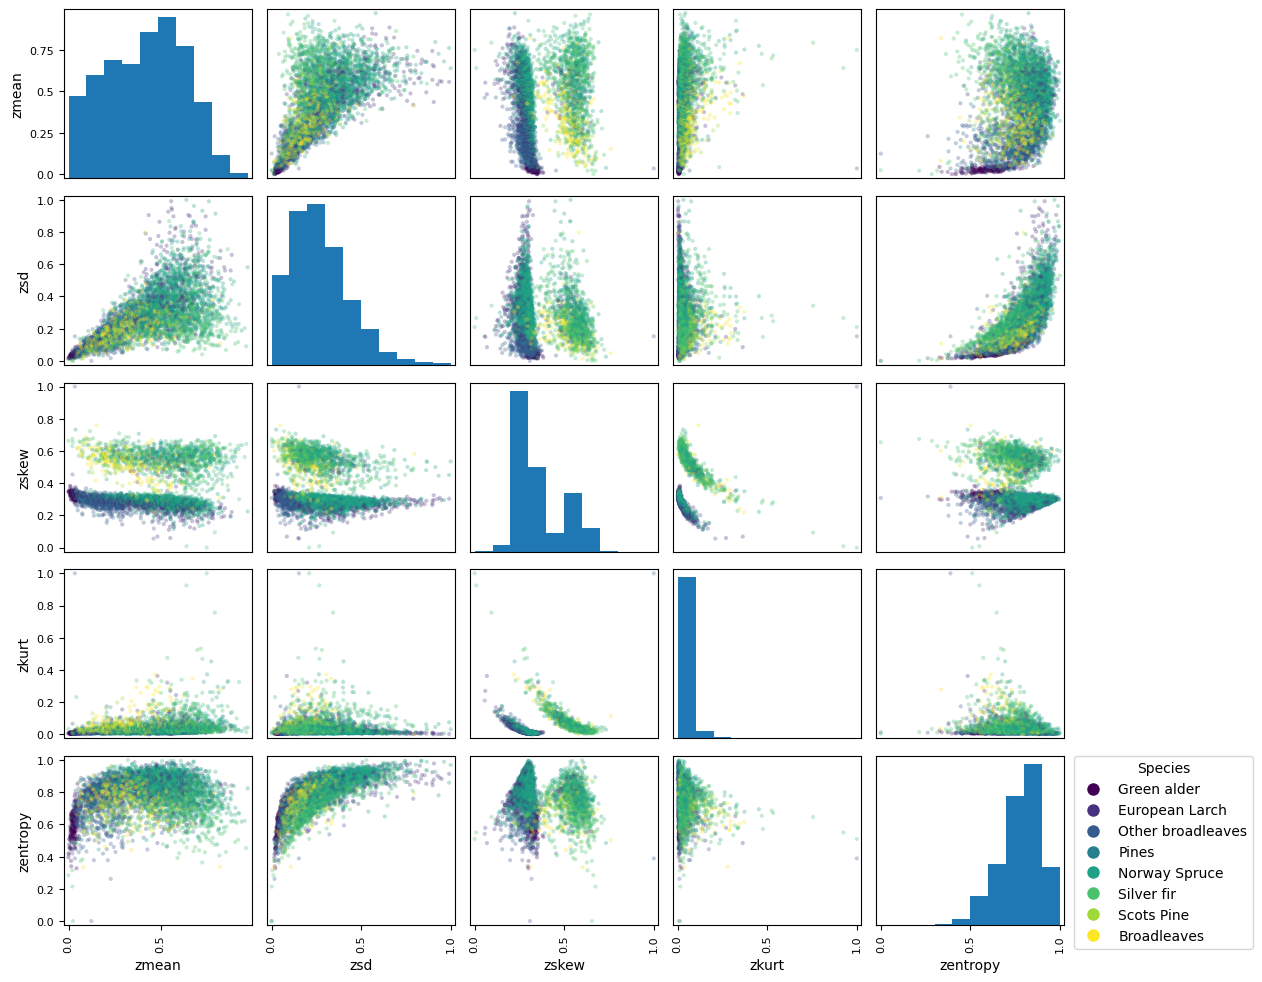

In [8]:
species_codes, species_labels = pd.factorize(full_labeled_df['Species'])

pd.plotting.scatter_matrix(
    full_labeled_df[height_features],
    c = species_codes,
    cmap = 'viridis',
    alpha = 0.3,
    figsize=(15, 10),
)

plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=label,
                   markerfacecolor=plt.cm.viridis(i / (len(species_labels) - 1)), markersize=10)
        for i, label in enumerate(species_labels)
    ],
    title = 'Species',
    bbox_to_anchor = (1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

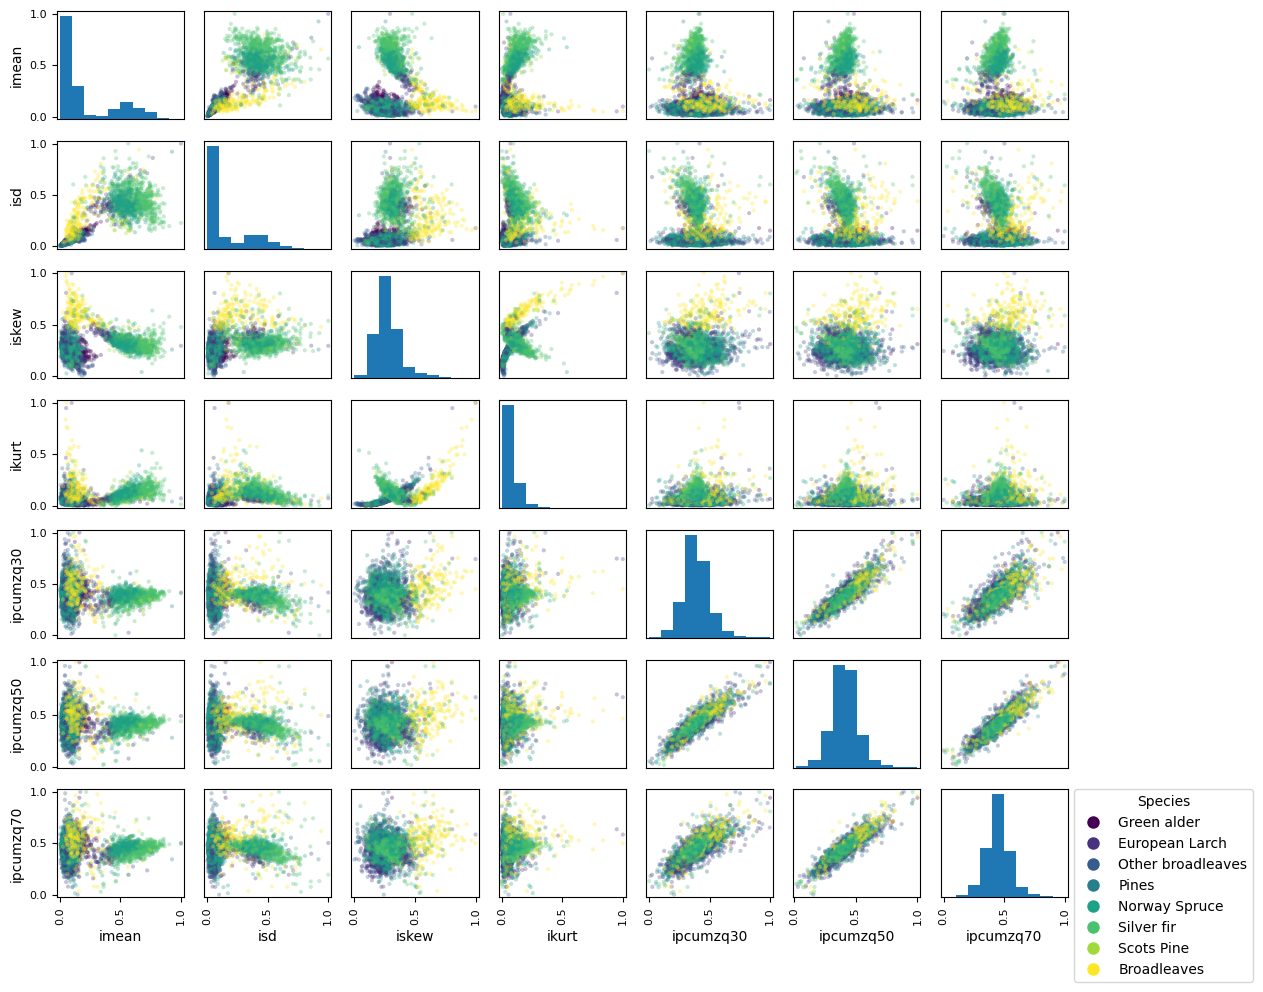

In [9]:
species_codes, species_labels = pd.factorize(full_labeled_df['Species'])

pd.plotting.scatter_matrix(
    full_labeled_df[intensity_features],
    c = species_codes,
    cmap = 'viridis',
    alpha = 0.3,
    figsize=(15, 10),
)

plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=label,
                   markerfacecolor=plt.cm.viridis(i / (len(species_labels) - 1)), markersize=10)
        for i, label in enumerate(species_labels)
    ],
    title = 'Species',
    bbox_to_anchor = (1.05, 1),
    loc = 'upper left',
    borderaxespad = 0.
)

plt.tight_layout(rect = [0, 0, 0.85, 1])
plt.show()

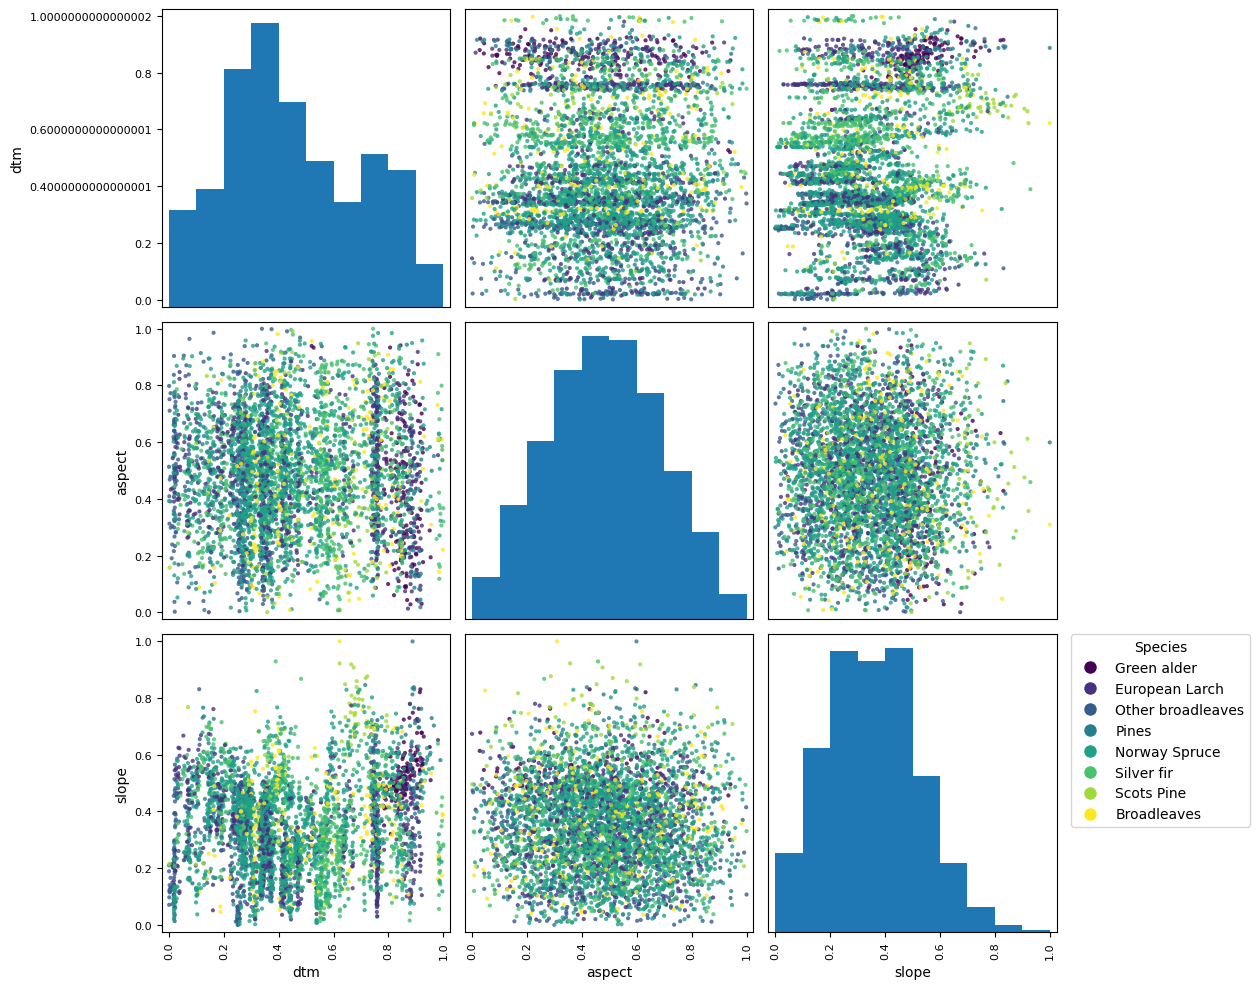

In [10]:
species_codes, species_labels = pd.factorize(full_labeled_df['Species'])

pd.plotting.scatter_matrix(
    full_labeled_df[topographical_features],
    c = species_codes,
    cmap = 'viridis',
    alpha = 0.8,
    figsize=(15, 10),
)

plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=label,
                   markerfacecolor=plt.cm.viridis(i / (len(species_labels) - 1)), markersize=10)
        for i, label in enumerate(species_labels)
    ],
    title='Species',
    bbox_to_anchor = (1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

## Data Splitting

Now, we use `data_splitting.py` to split the full dataframe into train/val/test datasets.

In [11]:
import torch
import data_splitting

In [12]:
train_dataset, val_dataset, test_dataset, full_dataset = data_splitting.get_labeled_datasets(
    full_labeled_df,
    smote = True,
    smote_scaling_dict = {0: 1, 1: 1, 2: 1, 3: 1.5,
                          4: 2, 5: 2, 6: 3, 7: 4}
    )

Here, we've used SMOTE in an attempt to mitigate the class imbalance. In the above function call, we specify how to scale the number of samples in each class. For example, for class 7 (the most spare class), we've specified that we want to end up with 4 times as many samples as we would have if we did not use SMOTE.

Using SMOTE comes with a tradeoff. Generating more samples does address the class imbalance. But, the more samples you generate, the less authentic data you have. This is a problem because the artificial data may not be as informative as the authentic data.

In [17]:
train_class_counts = torch.zeros(8).to(device)
for _, label in train_dataset:
    train_class_counts += label

train_class_counts, train_class_counts.sum()

(tensor([772., 299., 234., 342., 178., 150., 123.,  92.]), tensor(2190.))

## Model Construction and Training

Now, we use `tree_classifier.py` to construct and train the model.

In [18]:
import torch
import math
from torch.utils.data import DataLoader
from torch import nn

In [19]:
from tree_classifier import TreeClassifier
from tree_classifier import plot_training_progress

Here, we're specifying training hyperparameters. We're also specifying a weight vector `w`. This will be passed to `nn.CrossEntropyLoss` when we define the loss function.

In short, we use `w` to weigh the terms of the cross entropy loss function. Here, `w` is a vector with 8 entries, each corresponding to the 8 classes. We've defined `w` in a way that $w_i$ is inversely proportional to the number of samples in class $i$. So, $w_0$ will be the smallest entry (since class 0 has the most samples) and $w_7$ will be the largest entry (since class 7 has the least samples).

By passing `w` to `nn.CrossEntropyLoss`, we punish misclassification of the minority classes more heavily. This is a method of addressing class imbalance.

In [20]:
# Choosing hyperparameters
batch_size = 1000
learning_rate = 5e-3
epochs = 150

# class weights
w = torch.tensor([1/(1 + math.log(n))**2 for n in train_class_counts]).to(device)
w = w/torch.linalg.norm(w)
w

tensor([0.2364, 0.3081, 0.3320, 0.2961, 0.3620, 0.3829, 0.4095, 0.4537])

Then, we instantiate the model, dataloaders, the loss function, and our chosen optimizer (Adam)

In [21]:
# instantiate model
model = TreeClassifier()

# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size)

# choose loss function and optimization algorithm
loss_fn = nn.CrossEntropyLoss(
                              weight = w
                              )
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

Here, we train the model using the method `TreeClassifier.fit`. This returns a list of 4 numpy arrays, which we call `history`. This contains a record of the model's accuracy and average loss on the trianing set and validation set. These values are printed during the training process, and are plotted in the cell below.

In [22]:
# train model
history = model.fit(train_dataloader, val_dataloader, loss_fn,
                    optimizer, epochs, verbose = 1)

Epoch 1
Train Accuracy: 35.251%, Avg loss: 0.718899, Val Accuracy: 41.270%, Avg loss: 0.550944

-------------------------------
Epoch 2
Train Accuracy: 35.251%, Avg loss: 0.695758, Val Accuracy: 41.270%, Avg loss: 0.591585

-------------------------------
Epoch 3
Train Accuracy: 30.365%, Avg loss: 0.693206, Val Accuracy: 31.066%, Avg loss: 0.598259

-------------------------------
Epoch 4
Train Accuracy: 41.735%, Avg loss: 0.686440, Val Accuracy: 42.857%, Avg loss: 0.597407

-------------------------------
Epoch 5
Train Accuracy: 41.324%, Avg loss: 0.668405, Val Accuracy: 42.630%, Avg loss: 0.593093

-------------------------------
Epoch 6
Train Accuracy: 39.680%, Avg loss: 0.636001, Val Accuracy: 40.136%, Avg loss: 0.588120

-------------------------------
Epoch 7
Train Accuracy: 33.425%, Avg loss: 0.595440, Val Accuracy: 31.066%, Avg loss: 0.583973

-------------------------------
Epoch 8
Train Accuracy: 31.461%, Avg loss: 0.549928, Val Accuracy: 27.438%, Avg loss: 0.561947

--------

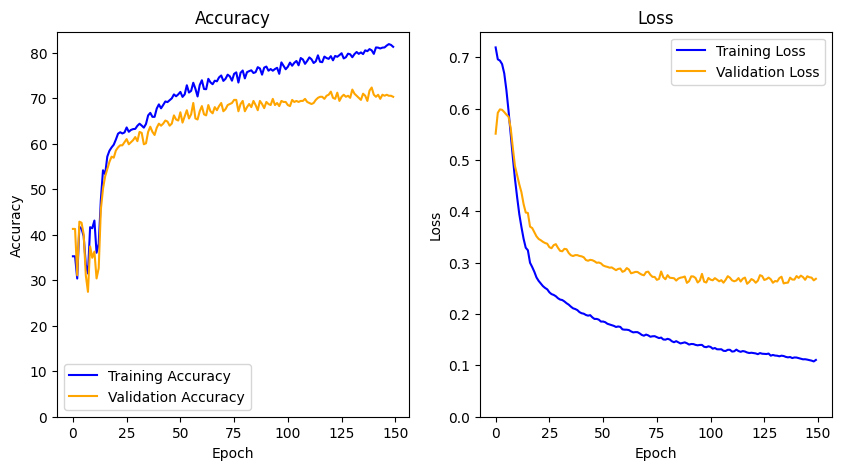

In [23]:
plot_training_progress(history)

Instead of training the model, one can also import the weights file `weights_trained_on_real.pth` as follows.

In [24]:
# torch.save(model, 'weights_trained_on_real.pth')
model = torch.load('weights_trained_on_real.pth', weights_only = False).to(device)
model.eval()

TreeClassifier(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=8, bias=True)
  )
)

## Testing

The file `model_metrics.py` contains several functions that allow us to evaluate our model's performance. Below, we test the model against the validation set, the test set, and the full data set.

In [25]:
import model_metrics

In [26]:
batch_size = 1024
model.eval()

TreeClassifier(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=8, bias=True)
  )
)

In [30]:
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)
full_dataloader = DataLoader(full_dataset, batch_size = batch_size)

Norway Spruce:  0.817
European Larch:  0.667
Other broadleaves:  0.771
Silver fir:  0.824
Broadleaves:  0.833
Green alder:  0.870
Pines:  0.522
Scots Pine:  0.778
Macro F1 Score:  0.760
Accuracy: 78.458%, Avg loss: 0.200287


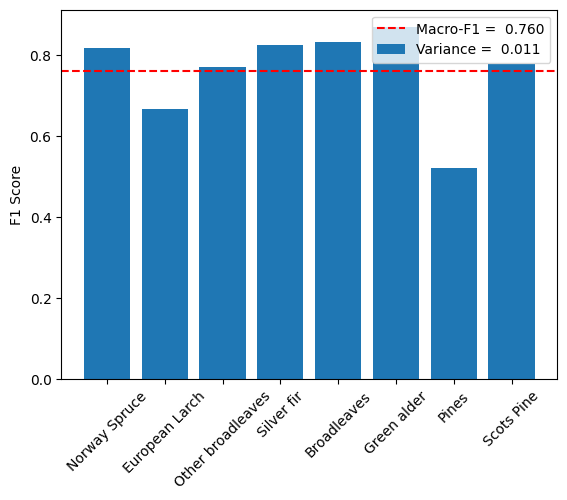

In [31]:
model_metrics.print_f1_scores(model, val_dataloader)
model.evaluate_accuracy(val_dataloader, loss_fn)
model_metrics.plot_f1_scores(model, val_dataloader)

Norway Spruce:  0.826
European Larch:  0.666
Other broadleaves:  0.840
Silver fir:  0.782
Broadleaves:  0.902
Green alder:  0.920
Pines:  0.605
Scots Pine:  0.752
Macro F1 Score:  0.787
Accuracy: 80.018%, Avg loss: 0.166734


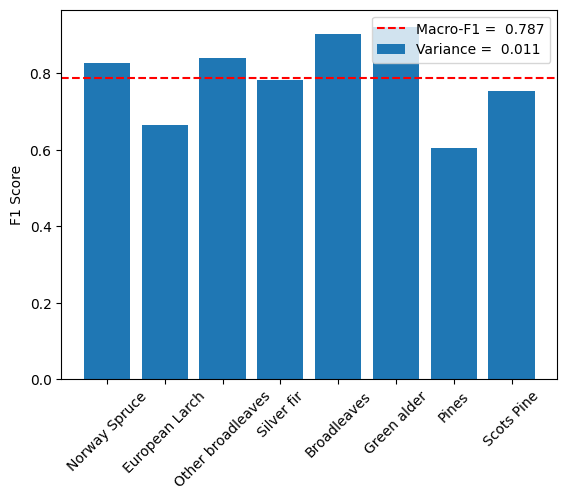

In [32]:
model_metrics.print_f1_scores(model, test_dataloader)
model.evaluate_accuracy(test_dataloader, loss_fn)
model_metrics.plot_f1_scores(model, test_dataloader)

Norway Spruce:  0.824
European Larch:  0.661
Other broadleaves:  0.820
Silver fir:  0.778
Broadleaves:  0.883
Green alder:  0.933
Pines:  0.582
Scots Pine:  0.711
Macro F1 Score:  0.774
Accuracy: 79.314%, Avg loss: 0.170951


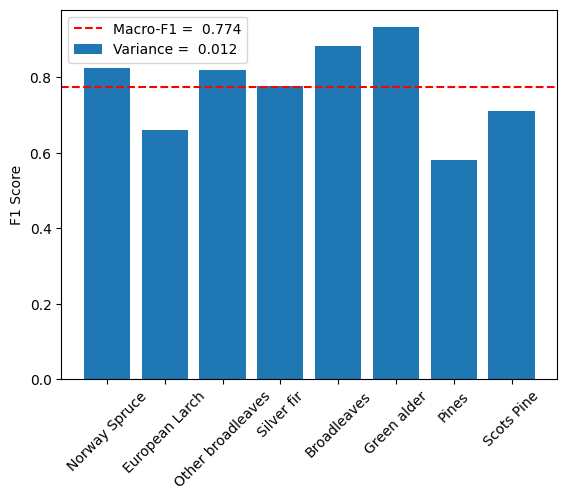

In [33]:
model_metrics.print_f1_scores(model, full_dataloader)
model.evaluate_accuracy(full_dataloader, loss_fn)
model_metrics.plot_f1_scores(model, full_dataloader)

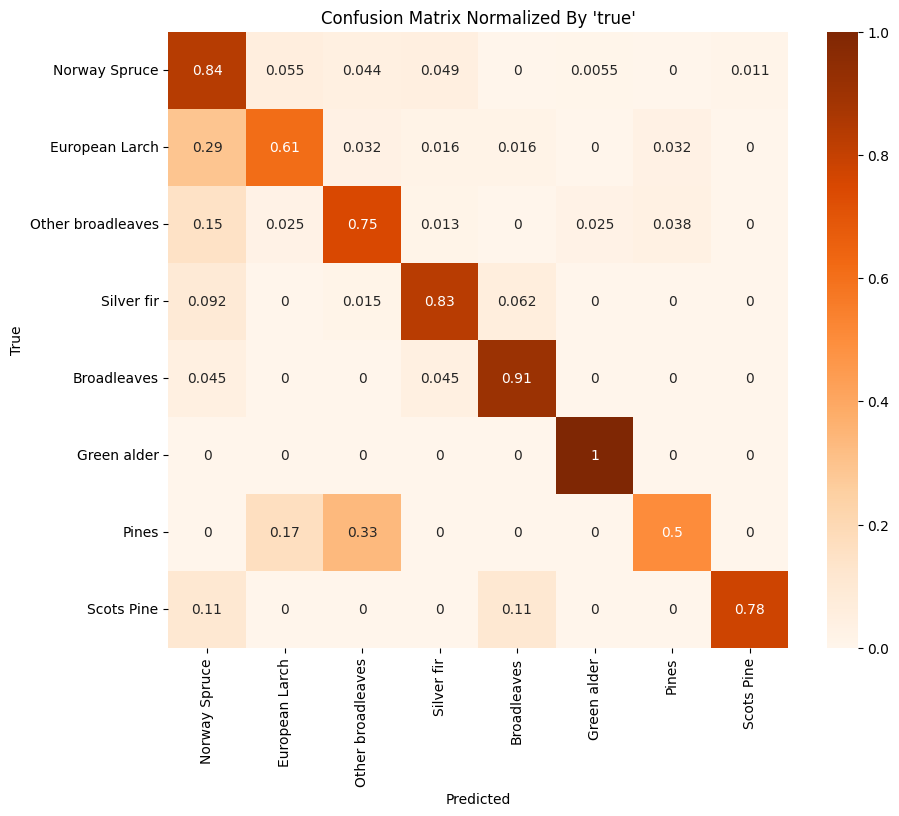

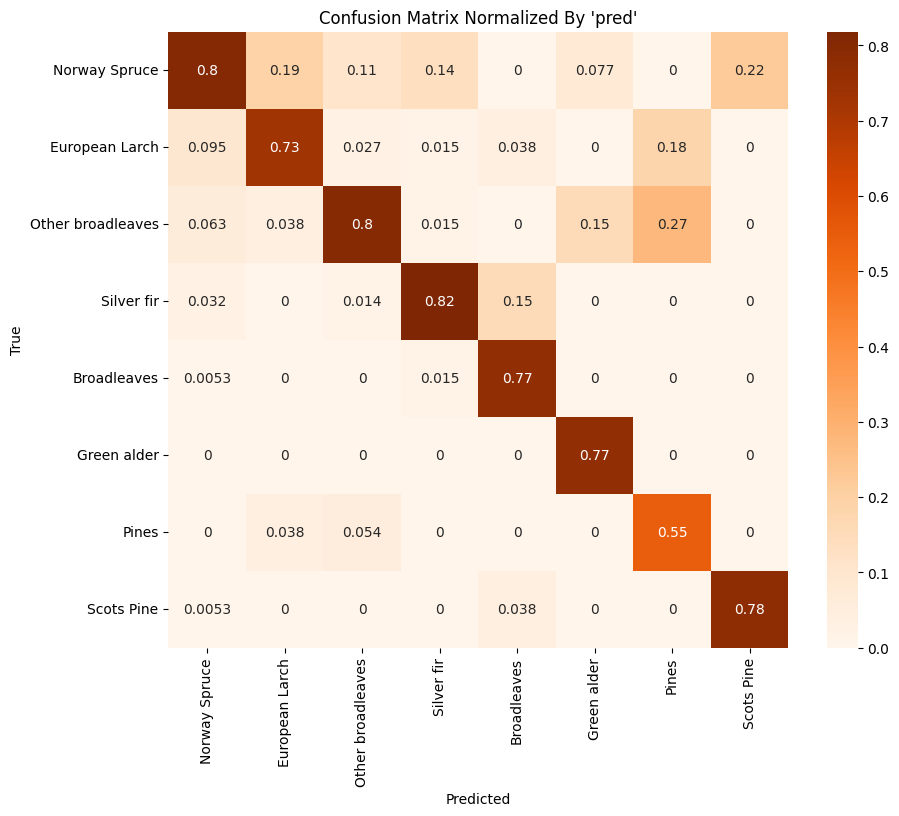

In [34]:
model_metrics.plot_confusion_matrix(model, val_dataloader, normalize = 'true')
model_metrics.plot_confusion_matrix(model, val_dataloader, normalize = 'pred')

# **Unsupervised Learning on Unlabeled Data**

Now, we apply our model to the unlabeled dataset and attempt to improve the model by training on samples with high pseudo-label confidence.

## Data Preprocessing

We again use functions from `data_preprocessing.py` and `data_splitting.py`

In [35]:
import torch

In [36]:
from data_preprocessing import process_unlabeled_data
from data_splitting import get_pseudo_labeled_dataframe, get_pseudo_labeled_datasets

Firstly, we merge the two unlabeled datasets into a single dataframe. This contains $\sim 6 \times 10^6$ samples.

In [37]:
full_unlabeled_df = process_unlabeled_data(
    ['/content/lidar-data/dataset_1_unlabeled_set.csv',
     '/content/lidar-data/dataset_2_unlabeled_set.csv']
)

len(full_unlabeled_df)

589040

If we don't have a model already, we can load a model as follows using the weights file `weights_trained_on_real.pth`.

In [38]:
model = torch.load('weights_trained_on_real.pth', weights_only = False)
model.eval()

TreeClassifier(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=8, bias=True)
  )
)

Now, we apply the model to our dataframe of unlabeled data.

In [39]:
full_pseudo_labeled_df = get_pseudo_labeled_dataframe(model, full_unlabeled_df)

This creates two new columns: "Predicted Species Number", which is the model's prediction, and "Prediction Confidence", which is the probability (according the model) that the tree is of the indicated species.

These values are obtained by applying softmax to the model's output (which is a vector in $\mathbb{R}^8$). The Predicted Species Number is the index of the largest entry, and the Prediction Confidence is the value of the largest entry after softmaxing.

In [41]:
full_pseudo_labeled_df

,zmean,zsd,zskew,zkurt,zentropy,imean,isd,iskew,ikurt,ipcumzq30,ipcumzq50,ipcumzq70,dtm,aspect,slope,Predicted Species Number,Prediction Confidence
0,0.012630,0.027047,0.355161,0.009817,0.549246,0.302994,0.143761,0.104912,0.008578,0.445052,0.472919,0.472604,0.447017,0.669231,0.501719,5,0.573461
1,0.209725,0.263911,0.300827,0.006719,0.933505,0.103212,0.062506,0.241720,0.064640,0.489041,0.462653,0.501309,0.440830,0.500784,0.562119,2,0.443966
2,0.448871,0.569468,0.303561,0.006640,0.985613,0.102878,0.074990,0.316441,0.108237,0.466069,0.477109,0.495326,0.442021,0.787530,0.583112,0,0.782043
3,0.014199,0.027105,0.339326,0.004762,0.574184,0.241848,0.122474,0.115224,0.011563,0.491613,0.599481,0.694269,0.441616,0.374625,0.578989,2,0.964157
4,0.019168,0.035299,0.314062,0.008375,0.555842,0.269245,0.124298,0.119512,0.009303,0.334508,0.450212,0.557486,0.440471,0.529620,0.601047,2,0.731815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160108,0.390024,0.278824,0.547313,0.030579,0.808914,0.031832,0.076033,0.707387,0.364640,0.369740,0.402976,0.306973,0.100029,0.513519,0.183696,4,0.998991
160109,0.394847,0.315343,0.469319,0.112954,0.821489,0.100869,0.280117,0.760758,0.323156,0.345475,0.406552,0.336741,0.098651,0.587402,0.182349,4,0.999871
160110,0.261547,0.360165,0.619580,0.005524,0.896465,0.159371,0.456136,0.578933,0.053638,0.240584,0.237263,0.419386,0.104838,0.629950,0.299034,4,0.994815
160111,0.349694,0.062197,0.477332,0.086535,0.450805,0.055841,0.055832,0.469574,0.083150,0.442480,0.404055,0.412057,0.097529,0.915755,0.207689,4,0.962437


In [44]:
full_pseudo_labeled_df['Predicted Species Number'].value_counts()

,count
Predicted Species Number,
0,190170
2,161929
4,62579
5,56332
3,55478
1,40482
6,16685
7,5385


<Axes: >

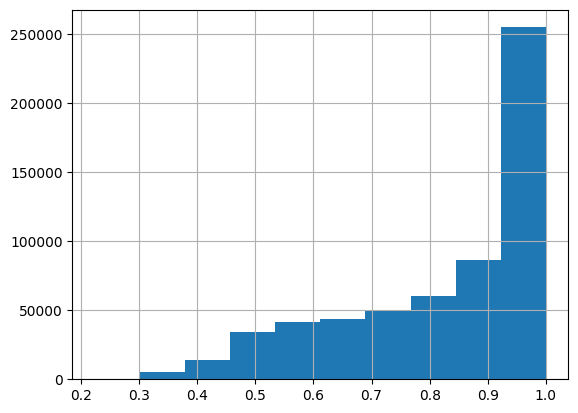

In [40]:
full_pseudo_labeled_df['Prediction Confidence'].hist()

## Data Splitting

In [42]:
from torch.utils.data import Dataset, DataLoader

In [43]:
from data_splitting import get_pseudo_labeled_datasets

Now, we form a new training set using the pseudo-labeled data. Here, the `threshold` parameter indicates which data samples to keep. Below, we've specified `threshold = 0.75`, so only samples whose pseudo-labels have confidence $\geq 0.75$ will be kept in the training set.

We opt not to use SMOTE here as we already have a large amount of data here.



In [45]:
train_pseudo_dataset = get_pseudo_labeled_datasets(
    model,
    full_pseudo_labeled_df,
    threshold = 0.75,
    smote = False,
    # smote_scaling_dict = {0: 1,
    #                      1: 1.5,
    #                      2: 1.5,
    #                      3: 1.5,
    #                      4: 2,
    #                      5: 2,
    #                      6: 2,
    #                      7: 2}
    )

In [46]:
len(train_pseudo_dataset)

412444

In [47]:
train_pseudo_class_counts = torch.zeros(8).to(device)
for _, label in train_pseudo_dataset:
    train_pseudo_class_counts += label

train_pseudo_class_counts, train_pseudo_class_counts.sum()

(tensor([116035.,  16770., 125213.,  38035.,  56755.,  49642.,   7659.,   2335.]),
 tensor(412444.))

We still observe class imbalance. We've opted not to use SMOTE, and isntead address this imbalance by using a more aggressive weighting scheme for our loss function

## Re-training Model On Pseudo-Labeled Data

In [48]:
import torch
import math
from torch.utils.data import DataLoader
from torch import nn

In [49]:
from tree_classifier import TreeClassifier, plot_training_progress

In [52]:
model = torch.load('weights_trained_on_real.pth', weights_only = False)
model.to(device)
model.eval()

TreeClassifier(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=8, bias=True)
  )
)

Here, we use a weighting scheme which shifts assigns more weight to the minority classes in a more aggressive manner compared to the scheme chosen when training on the labeled data.

Additionally, we train on less epochs because the pseudo-labeled dataset is much larger.

In [58]:
# Choosing hyperparameters
batch_size = 30000
learning_rate = 2.5e-4
epochs = 20

# class weights
w = torch.tensor([1/(n**(1/3)) for n in train_pseudo_class_counts]).to(device)
w = w/torch.linalg.norm(w)
w

tensor([0.1805, 0.3439, 0.1760, 0.2618, 0.2291, 0.2395, 0.4466, 0.6636])

Note: we continue to use the same validation set created earlier from the labeled dataset. We want to compare against data with labels that we are certain about.

In [59]:
# define dataloaders
train_pseudo_dataloader = DataLoader(train_pseudo_dataset, batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size)

# choose loss function and optimization algorithm
loss_fn = nn.CrossEntropyLoss(
                              weight = w
                              )
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [60]:
# train model
history = model.fit(train_pseudo_dataloader, val_dataloader, loss_fn,
                    optimizer, epochs, verbose = 1)

Epoch 1
Train Accuracy: 99.956%, Avg loss: 0.014235, Val Accuracy: 77.324%, Avg loss: 0.188426

-------------------------------
Epoch 2
Train Accuracy: 99.732%, Avg loss: 0.012797, Val Accuracy: 76.417%, Avg loss: 0.195306

-------------------------------
Epoch 3
Train Accuracy: 99.958%, Avg loss: 0.010432, Val Accuracy: 76.417%, Avg loss: 0.199062

-------------------------------
Epoch 4
Train Accuracy: 99.930%, Avg loss: 0.009379, Val Accuracy: 76.644%, Avg loss: 0.204150

-------------------------------
Epoch 5
Train Accuracy: 99.902%, Avg loss: 0.008593, Val Accuracy: 76.190%, Avg loss: 0.210674

-------------------------------
Epoch 6
Train Accuracy: 99.900%, Avg loss: 0.007938, Val Accuracy: 76.190%, Avg loss: 0.214741

-------------------------------
Epoch 7
Train Accuracy: 99.890%, Avg loss: 0.007421, Val Accuracy: 75.964%, Avg loss: 0.219611

-------------------------------
Epoch 8
Train Accuracy: 99.884%, Avg loss: 0.006977, Val Accuracy: 75.510%, Avg loss: 0.224089

--------

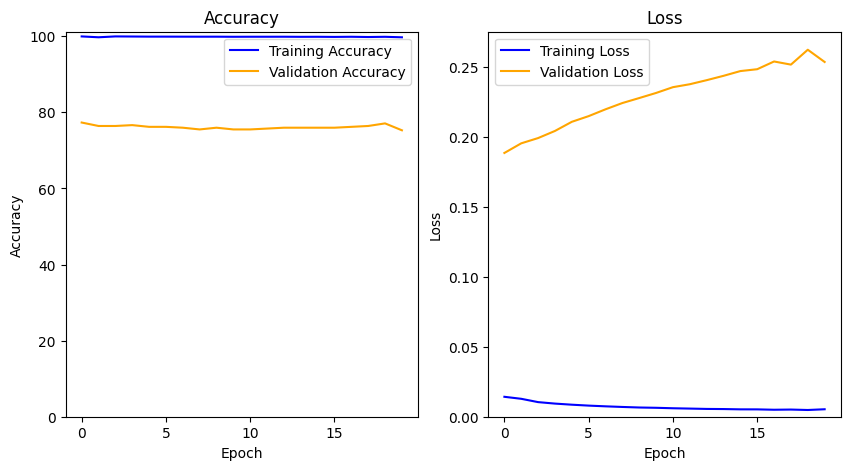

In [61]:
plot_training_progress(history)

We observe that training on the pseudo-labels slightly worsens the model's generalizability.

In [62]:
torch.save(model, 'weights_trained_on_pseudo.pth')
# model = torch.load('weights_trained_on_pseudo.pth', weights_only = False).to(device)
# model.eval()

## Testing

In [63]:
import model_metrics

In [64]:
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size)

Norway Spruce:  0.788
European Larch:  0.617
Other broadleaves:  0.748
Silver fir:  0.806
Broadleaves:  0.784
Green alder:  0.870
Pines:  0.500
Scots Pine:  0.667
Macro F1 Score:  0.723
Accuracy: 75.283%, Avg loss: 0.253419


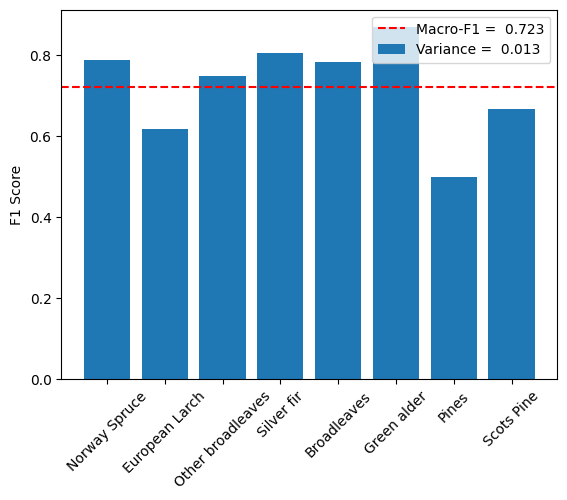

In [65]:
model_metrics.print_f1_scores(model, val_dataloader)
model.evaluate_accuracy(val_dataloader, loss_fn)
model_metrics.plot_f1_scores(model, val_dataloader)

Norway Spruce:  0.800
European Larch:  0.622
Other broadleaves:  0.820
Silver fir:  0.769
Broadleaves:  0.869
Green alder:  0.885
Pines:  0.599
Scots Pine:  0.667
Macro F1 Score:  0.754
Accuracy: 77.339%, Avg loss: 0.207008


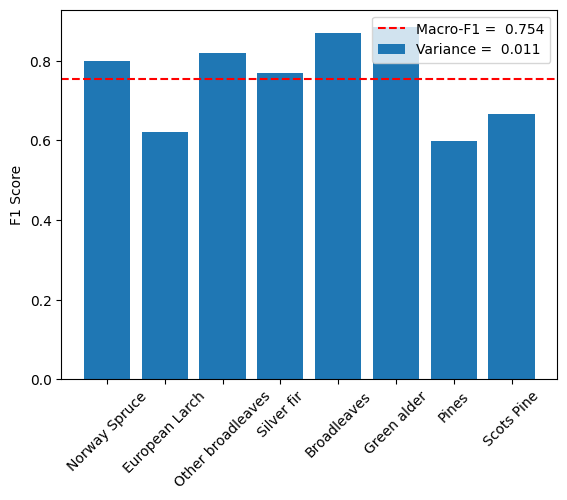

In [66]:
model_metrics.print_f1_scores(model, test_dataloader)
model.evaluate_accuracy(test_dataloader, loss_fn)
model_metrics.plot_f1_scores(model, test_dataloader)

Norway Spruce:  0.800
European Larch:  0.612
Other broadleaves:  0.804
Silver fir:  0.770
Broadleaves:  0.853
Green alder:  0.913
Pines:  0.577
Scots Pine:  0.624
Macro F1 Score:  0.744
Accuracy: 76.817%, Avg loss: 0.211924


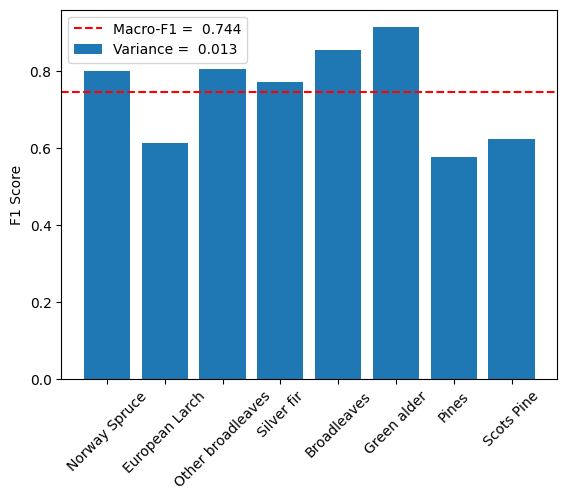

In [67]:
model_metrics.print_f1_scores(model, full_dataloader)
model.evaluate_accuracy(full_dataloader, loss_fn)
model_metrics.plot_f1_scores(model, full_dataloader)

After training on the labeled data, we obtained the following macro-F1 scores:
- Validation Set: 0.760
- Test Set: 0.787
- Full Labeled Set: 0.774

After training on the psuedo-labeled data, we obtained the following macro-F1 scores:
- Validation Set: 0.723
- Test Set: 0.754
- Full Labeled Set: 0.744

Notably, the performance has worsened. This most likely indicates that training on the pseudo-labels has led to overfitting on the training sets. Improvements can likely be made by decreasing the number of model parameters, tuning the number of samples created using SMOTE in the first training phase, and readjusting the loss function weights.